                                                Author: @Sarit Maitra


# Mutual Information
Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

The mutual information between two random variables X and Y can be stated formally as: I(X ; Y) = H(X) – H(X | Y)

- I(X ; Y) is the mutual information for X and Y, 
- H(X) is the entropy for X  
- H(X | Y) is the conditional entropy for X given Y. 

Mutual information is a measure of dependence or “mutual dependence” between two random variables. As such, the measure is symmetrical, meaning that I(X ; Y) = I(Y ; X).

Advantage of using mutual information over F-Test is, it does well with the non-linear relationship between feature and target variable.


**Wrapper methods tend to work very well in practice. However, they are computationally expensive, specially when dealing hundreds of features. If we have the computational resources, they are an excellent way to go**

In [1]:
%%time
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime, pickle, copy, warnings
from pandas import DataFrame, concat
import seaborn
import glob
import pandas.util.testing as tm
from functools import reduce
from pandas import DataFrame, merge, concat
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import seaborn as sns
import time
from sklearn.preprocessing import MaxAbsScaler
import scipy.linalg
import decimal
!pip install scikit-plot
import scikitplot
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.ticker as mtick
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.decomposition import PCA, KernelPCA
from numpy import where, meshgrid, arange, hstack
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import MiniBatchDictionaryLearning
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from numpy import mean, std

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<timed exec>:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Wall time: 27 s


In [2]:
%%time
df = pd.read_csv("july_futures_1min.csv")
df.set_index('timestamp', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)


d = df.copy()
#Classification
d['SP_frwd_ret'] = (d['es_close']/d['es_open']) -1

# If next period's return > 0, then 1, if next period's return <= 0, then 0
d['y'] = 0
# setting target as binary 
def getBinary(val):
    if val>=0:
        return 1
    else:
        return 0

d['y'] = d.SP_frwd_ret.apply(getBinary) # target
d.drop(['SP_frwd_ret', 'es_rets','es_open','es_high','es_low'], 1, inplace=True)
print('Original data shape:', d.shape); print()

fcast_out = int(1) # prediction for next 8 hrs
d['y'] = d['y'].shift(-fcast_out)
d.dropna(inplace=True)
print('Shifted data shape:', d.shape); print()

#Split data set
x = d.loc[:, d.columns != 'y']
y = d.loc[:, d.columns == 'y']

#Test set uses 20% of the data, no shuffle since we're dealing with time series.
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.20, shuffle=False)

#Summary
print("Train/Test Split Results:")
print("X Train Set:"); print(x_tr.shape)
print("X Test Set:");print(x_te.shape)

from sklearn.preprocessing import StandardScaler
#Initialize and fit scaler
scaler = StandardScaler()
#Fit scaler using the training data
scaler.fit(x_tr)

#Transform the raw data
x_tr_st = scaler.transform(x_tr)
x_te_st = scaler.transform(x_te)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original data shape: (31985, 93)

Shifted data shape: (31984, 93)



<IPython.core.display.Javascript object>

Train/Test Split Results:
X Train Set:
(25587, 92)
X Test Set:
(6397, 92)
Wall time: 644 ms


## Feature selection
Feature selection helps to zone in on the relevant variables in a data set, and can also help to eliminate collinear variables. It helps reduce the noise in the data set, and it helps the model pick up the relevant signals.

### Filter method:
Here we do not use a learning algorithm on the original data X, but only consider statistical characteristics of the input data. For example, we can select the features for which the correlation between the feature and the target variable exceeds a correlation threshold.

### Univariate Feature Selection

Ref: https://thuijskens.github.io/2017/10/07/feature-selection/

- Due to the non-linear nature of financial data, I have used mutual information as opposed to the F-test. 
- F-test estimates the degree of linear dependency between two random variables. 
- mutual information methods can capture any kind of statistical dependency

Mutual information is a measure between two multi-dimensional random variables X and Y, that quantifies the amount of information obtained about one random variable, through the other random variable.

**It is a non-parametric measure, therefore more the samples better for accurate estimation.**

Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [3]:
# FEATURE SELECTION
mi_select = SelectPercentile(mutual_info_classif, 
                             percentile=60).fit(x_tr_st,  np.ravel(y_tr))
x_tr_mi = mi_select.transform(x_tr_st)
x_te_mi = mi_select.transform(x_te_st)
print("Feature Selection Results:")
print("Filter Result:"); print("Number of features: ", x_tr_mi.shape[1])

<IPython.core.display.Javascript object>

Feature Selection Results:
Filter Result:
Number of features:  55


<IPython.core.display.Javascript object>

Feature 0: 0.007150
Feature 1: 0.001917
Feature 2: 0.010177
Feature 3: 0.007383
Feature 4: 0.008058
Feature 5: 0.010654
Feature 6: 0.005503
Feature 7: 0.006901
Feature 8: 0.006425
Feature 9: 0.009634
Feature 10: 0.002475
Feature 11: 0.009494
Feature 12: 0.007626
Feature 13: 0.005547
Feature 14: 0.006522
Feature 15: 0.011324
Feature 16: 0.004115
Feature 17: 0.005736
Feature 18: 0.001518
Feature 19: 0.004848
Feature 20: 0.002127
Feature 21: 0.004052
Feature 22: 0.003633
Feature 23: 0.006039
Feature 24: 0.007949
Feature 25: 0.008847
Feature 26: 0.002981
Feature 27: 0.002735
Feature 28: 0.000000
Feature 29: 0.002907
Feature 30: 0.005142
Feature 31: 0.008049
Feature 32: 0.006063
Feature 33: 0.002421
Feature 34: 0.006020
Feature 35: 0.004421
Feature 36: 0.008091
Feature 37: 0.013961
Feature 38: 0.004143
Feature 39: 0.003519
Feature 40: 0.009441
Feature 41: 0.004860
Feature 42: 0.002025
Feature 43: 0.009550
Feature 44: 0.001659
Feature 45: 0.006817
Feature 46: 0.002177
Feature 47: 0.000000
Fe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

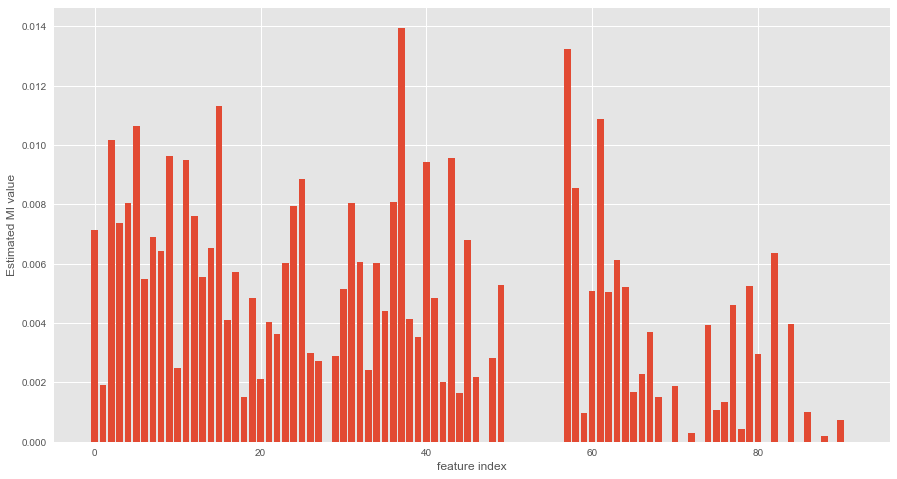

In [5]:
#feature_names = x.columns
# feature selection
def select_features(x_tr_st, y_tr_st, x_te):
    # configure to select all features
    mi = SelectPercentile(mutual_info_classif, 
                             percentile=60).fit(x_tr_st,  np.ravel(y_tr))
    # transform train input data
    x_tr_mi = mi.transform(x_tr_st)
    # transform test input data
    x_te_mi = mi.transform(x_te_st)
    return x_tr_mi, x_te_mi, mi

# feature selection
x_tr_mi, x_te_mi, mi = select_features(x_tr_st, y_tr, x_te_st)
# what are scores for the features
for i in range(len(mi.scores_)):
    print('Feature %d: %f' % (i, mi.scores_[i]))
# plot the scores
plt.style.use('ggplot')
plt.figure(figsize=(15,8))
plt.bar([i for i in range(len(mi.scores_))], mi.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
#plt.xticks(range(fs_scores.shape[1]), feature_names)
plt.show()

The y-axis represents the estimated mutual information between each feature and the target variable. Compared to the correlation feature selection method we can clearly see many more features scored as being relevant. This may be because of the statistical noise that might exists in the dataset.

We want to see the relationship between the number of selected features and classification accuracy. In this relationship, we may expect that more features result in a better performance to a point.

We will explore this relationship by manually evaluating each configuration of k for the SelectKBest from 1 to 22 features, gathering the sample of accuracy scores, and plotting the results using box and whisker plots side-by-side. 

The spread and mean of these box plots would be expected to show any interesting relationship between the number of selected features and the classification accuracy of the pipeline.


**need to run below example a few times to compare the average outcome**

=>1 0.533 (0.008)
=>2 0.546 (0.008)
=>3 0.546 (0.010)
=>4 0.546 (0.009)
=>5 0.552 (0.008)
=>6 0.552 (0.008)
=>7 0.558 (0.009)
=>8 0.562 (0.008)
=>9 0.561 (0.009)
=>10 0.562 (0.009)
=>11 0.564 (0.009)
=>12 0.563 (0.007)
=>13 0.564 (0.007)
=>14 0.567 (0.008)
=>15 0.565 (0.008)
=>16 0.565 (0.008)
=>17 0.565 (0.008)
=>18 0.566 (0.008)
=>19 0.565 (0.009)
=>20 0.567 (0.008)
=>21 0.567 (0.007)
=>22 0.568 (0.009)
=>23 0.569 (0.008)
=>24 0.566 (0.007)
=>25 0.566 (0.008)
=>26 0.565 (0.008)
=>27 0.569 (0.007)
=>28 0.567 (0.007)
=>29 0.568 (0.007)
=>30 0.568 (0.007)
=>31 0.568 (0.007)
=>32 0.568 (0.007)
=>33 0.570 (0.005)
=>34 0.570 (0.005)
=>35 0.569 (0.007)
=>36 0.570 (0.006)
=>37 0.570 (0.007)
=>38 0.572 (0.007)
=>39 0.572 (0.007)
=>40 0.572 (0.005)
=>41 0.571 (0.008)
=>42 0.572 (0.008)
=>43 0.572 (0.007)
=>44 0.572 (0.006)
=>45 0.573 (0.007)
=>46 0.573 (0.008)
=>47 0.573 (0.007)
=>48 0.573 (0.007)
=>49 0.573 (0.006)
=>50 0.572 (0.007)
=>51 0.572 (0.005)
=>52 0.572 (0.007)
=>53 0.572 (0.006)
=>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

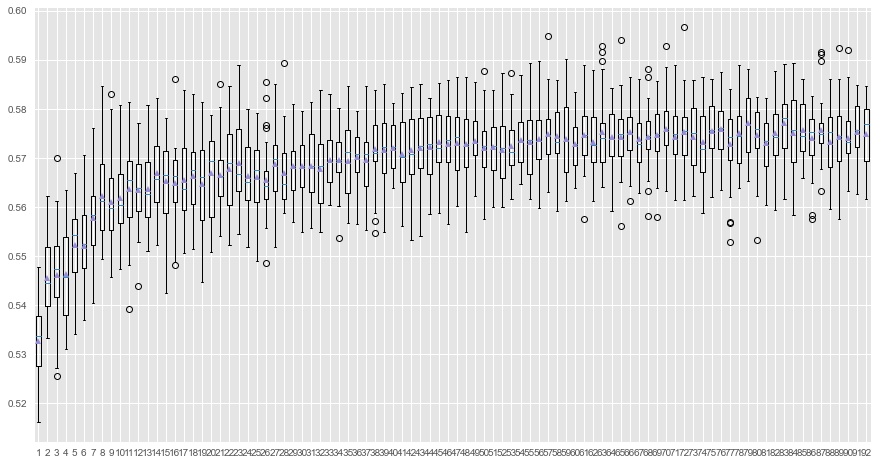

In [6]:
# number of features 
num_features = [i+1 for i in range(x.shape[1])]
# evaluate a give model using CV
def evaluate_model(model, x_tr_st, y_tr):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_tr_st, y_tr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# enumerate each number of features
results = list()
for k in num_features:
    # pipeline
    model = RandomForestClassifier()
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('MutualInformation', fs), ('rf', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, x_tr_st, y_tr)
    results.append(scores)
    # results summary
    print('=>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
plt.style.use('ggplot')
plt.figure(figsize=(15,8))
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

In [7]:
sklearn.metrics.SCORERS.keys()

<IPython.core.display.Javascript object>

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

# CAUTION :: computationaly expensive

<IPython.core.display.Javascript object>


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1080x576 with 0 Axes>

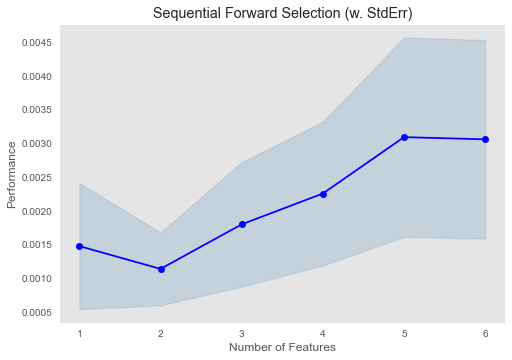

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

model = RandomForestClassifier()
sfs = SFS(model, 
          k_features=92, 
          forward=True, 
          floating=False, 
          scoring='mutual_info_score',
          cv=10).fit(x_tr_st, np.ravel(y_tr))
plt.figure(figsize=(15,8))
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()